In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sagemaker
from sagemaker.local import LocalSession

#sagemaker_session = LocalSession()
#sagemaker_session.config = {'local': {'local_code': True}}
sagemaker_session=sagemaker.Session()

role = sagemaker.get_execution_role()
bucket_name = sagemaker_session.default_bucket()
prefix='sine'

## 1) First, lets create a custom entrypoint to define different encoding/decoding types

In [48]:
%%writefile inference.py
import json
import requests

def handler(data, context):
    """Handle request.
    Args:
        data (obj): the request data
        context (Context): an object containing request and configuration details
    Returns:
        (bytes, string): data to return to client, (optional) response content type
    """
    processed_input,ids = _process_input(data, context)
    # Here we're using the HTTP endpoint. It requires JSON format
    # based on the TF standards: https://www.tensorflow.org/tfx/serving/api_rest#predict_api
    # If you need more performance, try the grpc_uri protocol instead    
    response = requests.post(context.rest_uri, data=processed_input)
    return _process_output(response, context, ids)


def _process_input(data, context):
    if context.request_content_type == 'text/csv':        
        input_data = data.read().decode('utf-8')        
        # very simple csv handler
        instances = []
        ids = []
        for i in input_data.split('\n'): # the first element is the id, the rest is payload            
            if len(i) == 0: continue
            row = i.split(',')            
            ids.append(int(row[0])) # id of the request
            instances.append([float(row[1])]) # body of the request
        
        return json.dumps({'instances': instances}), ids

    raise ValueError('{{"error": "unsupported content type {}"}}'.format(
        context.request_content_type or "unknown"))

def _process_output(data, context, ids):    
    if data.status_code != 200:        
        raise ValueError(data.content.decode('utf-8'))
    
    if context.accept_header == 'text/csv':
        preds = []
        idx = 0
        for row in json.loads(data.content.decode('utf-8'))['predictions']:
            for pred in row:
                preds.append("%d,%.05f" % (ids[idx], pred))
                idx += 1
        return "\n".join(preds), context.accept_header

    raise ValueError('{{"error": "unsupported accept type {}"}}'.format(
        context.accept_header or "unknown"))

Overwriting inference.py


## 2) Now, we can define the SageMaker Model

In [75]:
from sagemaker.tensorflow import TensorFlowModel
import logging

key = "%s/model.tar.gz" % prefix
sm_model = TensorFlowModel(
    "s3://%s/%s" % (bucket_name, key ),
    role,
    sagemaker_session=sagemaker_session,
    entry_point="inference.py",
    framework_version="2.3.1",
    container_log_level=logging.DEBUG
)

## 3) If you want to test the solution locally first, deploy the following local endpoint

In [ ]:
predictor = sm_model.deploy(initial_instance_count=1, instance_type='local')

In [53]:
import boto3
import io
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import NumpyDeserializer

s3_client = boto3.client('s3')
with io.BytesIO() as data:
    key = "%s/batch/input/file_%03d.csv" % (prefix, 0 )
    s3_client.download_fileobj(bucket_name, key, data)
    data.seek(0)
    x_test = np.genfromtxt(data, delimiter=',')    
predictor.serializer = CSVSerializer()
predictor.deserializer = NumpyDeserializer(accept='text/csv')#CSVDeserializer()

preds = predictor.predict([(int(x[0]),float(x[1])) for x in x_test])

r4y560c2st-algo-1-43ti1 | INFO:python_service:http://gunicorn_upstream/invocations
r4y560c2st-algo-1-43ti1 | INFO:tfs_utils:sagemaker tfs attributes: 
r4y560c2st-algo-1-43ti1 | {}
r4y560c2st-algo-1-43ti1 | 172.18.0.1 - - [20/Feb/2021:11:32:21 +0000] "POST /invocations HTTP/1.1" 200 12352 "-" "python-urllib3/1.26.3"


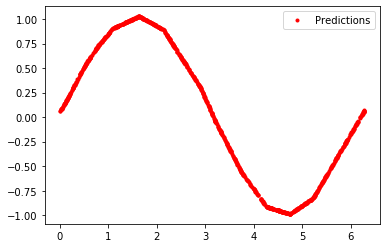

In [56]:
plt.plot([x[1] for x in x_test], [x[1] for x in preds], 'r.', label="Predictions")
plt.legend()
plt.show()

In [ ]:
predictor.delete_endpoint()

## 4) Now, lets process all the generated files in batch (on the cloud)

In [ ]:
transformer = sm_model.transformer(
    4,
    'ml.c4.xlarge', 
    strategy='MultiRecord', # sagemaker sends as many lines as it can read to each round
    assemble_with='Line',
    accept='text/csv',
    output_path="s3://%s/%s/batch/output" % (bucket_name, prefix), 
)
transformer.transform(
    "s3://%s/%s/batch/input" % (bucket_name, prefix), 
    data_type='S3Prefix', 
    content_type='text/csv', 
    split_type='Line',
    wait=True,
    logs=True
)

### 4.1) Ok. Finally, let's take a look on the results

In [70]:
import boto3
import io

s3_client = boto3.client('s3')

In [77]:
%%time
## Loading the input/output files
x_test = []
y_test = []
for file_id in range(1000):
    if file_id % 50 == 0:
        print('Progress: %d/1000' % (file_id+1))
    with io.BytesIO() as data:
        key = "%s/batch/input/file_%03d.csv" % (prefix, file_id)
        s3_client.download_fileobj(bucket_name, key, data)
        data.seek(0)
        x = np.genfromtxt(data, delimiter=',')
        
    with io.BytesIO() as data:
        key = "%s/batch/output/file_%03d.csv.out" % (prefix, file_id)
        s3_client.download_fileobj(bucket_name, key, data)
        data.seek(0)
        y = np.genfromtxt(data, delimiter=',')
        
    for feat, pred in zip(x,y):
        assert(feat[0] == pred[0])
        x_test.append(feat[1])
        y_test.append(pred[1])

Progress: 1/1000
Progress: 51/1000
Progress: 101/1000
Progress: 151/1000
Progress: 201/1000
Progress: 251/1000
Progress: 301/1000
Progress: 351/1000
Progress: 401/1000
Progress: 451/1000
Progress: 501/1000
Progress: 551/1000
Progress: 601/1000
Progress: 651/1000
Progress: 701/1000
Progress: 751/1000
Progress: 801/1000
Progress: 851/1000
Progress: 901/1000
Progress: 951/1000
CPU times: user 25.4 s, sys: 639 ms, total: 26 s
Wall time: 1min 56s


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


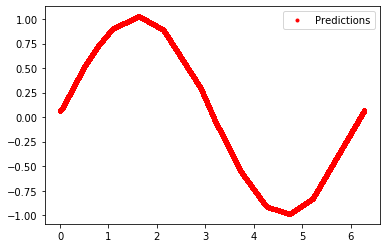

In [78]:
plt.plot(x_test, y_test, 'r.', label="Predictions")
plt.legend()
plt.show()